# --- SOLUTION ---

HINT: These solutions only give an impression on how the problems can be tackled. They are neither the best possible solutions nor are they always complete. You are invited to find approaches that outperform those given in the solutions and present them to your fellow students.

# Exercise 2: Ensembles

This exercise is about ensembles. To get familiar with ensembles in scikit-learn, refer to the respective [part in the documentation](https://scikit-learn.org/stable/modules/ensemble.html).

## Task 1: Warm-up
To get you started with ensemble learning, have a look at the `dart` data set that is provided in ILIAS. It contains the positions of darts thrown by four different people. First, we learn two basic classifiers on this data set. In a second step, we apply stacking to improve the performance.

- Train a k-NN (with `n_neighbors=1`) and a SVM (with `C=5`) and check their accuracy on the test set
- Inspect the classifications on the training data. What can you say about the decision boundaries?
- Combine the two classifiers by stacking (use a decision tree as meta learner). Does it improve the accuracy on the test set?
- Create a new attribute `distance from centre`. How does the accuracy change?

<sub>This task was originally published in https://gormanalysis.com/guide-to-model-stacking-i-e-meta-ensembling/</sub>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv('dart/dart_train.csv', sep=',').drop(columns='ID')
X_train, y_train = df_train.drop(columns='Competitor'), df_train['Competitor']

df_test = pd.read_csv('dart/dart_test.csv', sep=',').drop(columns='ID')
X_test, y_test = df_test.drop(columns='Competitor'), df_test['Competitor']

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train a k-NN and a SVM and check their performance on the test set.

# --- SOLUTION ---
def evaluate_classifier(e_name, e, X_train, y_train, X_test, y_test):
    y_pred = e.fit(X_train, y_train).predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'{e_name}: ACC={acc:.2f}')

estimators = {'k-NN': KNeighborsClassifier(n_neighbors=1), 'SVM': SVC()}
for e_name, e in estimators.items():
    evaluate_classifier(e_name, e, X_train, y_train, X_test, y_test)

k-NN: ACC=0.70
SVM: ACC=0.70


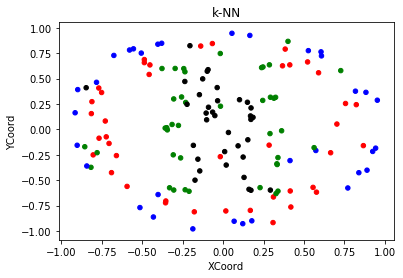

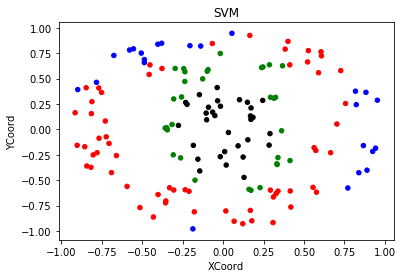

In [3]:
# Inspect the classifications on the training data (using a scatter plot).

# --- SOLUTION ---
def draw_classification_scatter(e_name, e, X_train, y_train):
    y_pred = e.fit(X_train, y_train).predict(X_train)
    colors = {'Bob': 'Blue', 'Sue': 'Red', 'Kate': 'Green', 'Mark': 'Black'}
    X_train.plot.scatter(x='XCoord', y='YCoord', c=[colors[x] for x in y_pred])
    plt.title(e_name)
    plt.show()

for e_name, e in estimators.items():
    draw_classification_scatter(e_name, e, X_train, y_train)

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Combine the two classifiers using stacking with a decision tree as meta learner. Measure the accuracy on the test set.
# Stacking: scikit-learn has no implementation for Stacking. You can use this -> http://ml-ensemble.com/
# HINT: mlens can only work with numerical labels. You can use the LabelEncoder to transform your labels.

# --- SOLUTION ---
from mlens.ensemble import SuperLearner

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

ensemble = SuperLearner()
ensemble.add(list(estimators.values()))
ensemble.add_meta(DecisionTreeClassifier())
estimators['Stacking'] = ensemble

for e_name, e in estimators.items():
    evaluate_classifier(e_name, e, X_train, y_train_encoded, X_test, y_test_encoded)

[MLENS] backend: threading


k-NN: ACC=0.70
SVM: ACC=0.70
Stacking: ACC=0.76


In [5]:
# Create the attribute 'distance_from_centre' and measure the accuracy on the test set (for base classifiers and stacking)

# --- SOLUTION ---
from sklearn.metrics import euclidean_distances

def add_distance(X):
    return X.assign(distance_from_centre=euclidean_distances(X, [[0, 0]]))

for e_name, e in estimators.items():
    evaluate_classifier(e_name, e, add_distance(X_train), y_train_encoded, add_distance(X_test), y_test_encoded)

k-NN: ACC=0.73
SVM: ACC=0.62
Stacking: ACC=0.78


Conclusion: Stacking can improve the performance of classification tasks. It also works well in combination with additionally created features.

## Task 2: Data Mining Cup 2006

Now we apply ensembles to the data set of the Data Mining Cup 2006. The task is to predict the attribute `gms_greater_avg` as precisely as possible. We again use accuracy as performance metric.

Please make sure to understand the principles of Voting, Bagging, Boosting, and Stacking before you work on this task.

- Build a baseline with several classifiers (like k-NN, Decision Tree, SVM, Naive Bayes, Neural Network,..)
- Use Bagging to improve the performance of the classifiers. How do they perform compared to a Random Forest?
- Try out boosting techniques (like AdaBoost and XGBoost). Do they work better?
- Finally, try to get the best results using various kinds of ensembles. You could try to combine several classifiers with Voting or Stacking!

In [6]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('dmc2006/dmc2006_train.txt', sep='\t', encoding='cp1252').drop(columns=['auct_id', 'gms', 'listing_title', 'listing_subtitle', 'listing_start_date', 'listing_end_date'])
X, y = df.drop(columns='gms_greater_avg'), df['gms_greater_avg']

# converting columns to have reasonable format
X = pd.get_dummies(X, columns=['item_leaf_category_name'])
boolean_columns = [k for k, v in X.dtypes.items() if v == np.object]
X[boolean_columns] = X[boolean_columns].apply(lambda row: [1 if x == 'Y' else 0 for x in row])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Make baseline predictions for the classifiers k-NN, Decision Tree, SVM, Naive Bayes, Neural Network

# --- SOLUTION ---
estimators = {
    'k-NN-1': KNeighborsClassifier(n_neighbors=1),
    'k-NN-3': KNeighborsClassifier(n_neighbors=3),
    'k-NN-5': KNeighborsClassifier(n_neighbors=5),
    'DT': DecisionTreeClassifier(),
    'SVM': SVC(),
    'NB': GaussianNB(),
    'NN': MLPClassifier()
}

for e_name, e in estimators.items():
    evaluate_classifier(e_name, e, X_train, y_train, X_test, y_test)

k-NN-1: ACC=0.63
k-NN-3: ACC=0.63
k-NN-5: ACC=0.63
DT: ACC=0.66
SVM: ACC=0.58
NB: ACC=0.58
NN: ACC=0.62


In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Use Bagging to improve the performance. Additionaly, check how a Random Forest classifier performs

# --- SOLUTION ---
bagging_estimators = {f'{e_name} (B)': BaggingClassifier(e) for e_name, e in estimators.items()}
estimators.update(bagging_estimators)
estimators['RF'] = RandomForestClassifier()

for e_name, e in estimators.items():
    evaluate_classifier(e_name, e, X_train, y_train, X_test, y_test)

k-NN-1: ACC=0.63
k-NN-3: ACC=0.63
k-NN-5: ACC=0.63
DT: ACC=0.65
SVM: ACC=0.58
NB: ACC=0.58
NN: ACC=0.64
k-NN-1 (B): ACC=0.62
k-NN-3 (B): ACC=0.64
k-NN-5 (B): ACC=0.63
DT (B): ACC=0.66
SVM (B): ACC=0.58
NB (B): ACC=0.58
NN (B): ACC=0.63
RF: ACC=0.66


In [13]:
from sklearn.ensemble import AdaBoostClassifier

# Try out AdaBoost and XGBoost
# XGBoost: scikit-learn does not implement XGBoost. Use this -> https://xgboost.readthedocs.io/en/latest/index.html
# (If you have problem with running XGBoost, this might help: https://stackoverflow.com/questions/61971851/getting-this-simple-problem-while-importing-xgboost-on-jupyter-notebook)

# --- SOLUTION ---
from xgboost import XGBClassifier

estimators['AdaBoost'] = AdaBoostClassifier()
estimators['XGBoost'] = XGBClassifier(use_label_encoder=False)

for e_name, e in estimators.items():
    evaluate_classifier(e_name, e, X_train, y_train, X_test, y_test)

k-NN-1: ACC=0.63
k-NN-3: ACC=0.63
k-NN-5: ACC=0.63
DT: ACC=0.66
SVM: ACC=0.58
NB: ACC=0.58
NN: ACC=0.59
k-NN-1 (B): ACC=0.63
k-NN-3 (B): ACC=0.64
k-NN-5 (B): ACC=0.64
DT (B): ACC=0.65
SVM (B): ACC=0.59
NB (B): ACC=0.58
NN (B): ACC=0.64
RF: ACC=0.66
AdaBoost: ACC=0.63
[10:43:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost: ACC=0.68


In [ ]:
# Now try to improve your results by applying other ensemble techniques (e.g. Voting, Stacking)
# or anything else that comes to your mind. How much can you improve the results?

# OPEN END QUESTION - try to improve your results as much as possible!